# Generate Synthetic Data

In this chapter, we talk about how we generate the synthetic data of participants' biomarker measurements. These data are used to test our algorithms.  

## Obtain Estimated Distribution Parameters

In @sec-gen, we mentioned that EBM can be used as a generative model and we need to know $S, \theta, \phi$ and $k_j$.

First, we obtained  $S, \theta, \phi$ from @chen2016staging:

![Theta and Phi from Chen's Paper](img/chen1.png){#fig-chen1}

![S from Chen's Paper](img/chen2.png){#fig-chen2}

This is our estimation:

In [15]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import json 
import scipy.stats as stats
from typing import List, Optional, Tuple, Dict
import os 
import seaborn as sns
import altair as alt 

In [16]:
#| code-fold: true

all_ten_biomarker_names = np.array([
    'MMSE', 'ADAS', 'AB', 'P-Tau', 'HIP-FCI', 
    'HIP-GMI', 'AVLT-Sum', 'PCC-FCI', 'FUS-GMI', 'FUS-FCI'])
# in the order above
# cyan, normal
phi_means = [28, -6, 250, -25, 5, 0.4, 40, 12, 0.6, -10]
# black, abnormal
theta_means = [22, -20, 150, -50, -5, 0.3, 20, 5, 0.5, -20]
# cyan, normal
phi_std_times_three = [2, 4, 150, 50, 5, 0.7, 45, 12, 0.2, 10]
phi_stds = [std_dev/3 for std_dev in phi_std_times_three]
# black, abnormal
theta_std_times_three = [8, 12, 50, 100, 20, 1, 20, 10, 0.2, 18]
theta_stds = [std_dev/3 for std_dev in theta_std_times_three]

# to get the real_theta_phi means and stds
hashmap_of_dicts = {}
for i, biomarker in enumerate(all_ten_biomarker_names):
    dic = {}
    # dic = {"biomarker": biomarker}
    dic['theta_mean'] = theta_means[i]
    dic['theta_std'] = theta_stds[i]
    dic['phi_mean'] = phi_means[i]
    dic['phi_std'] = phi_stds[i]
    hashmap_of_dicts[biomarker] = dic 
hashmap_of_dicts

real_theta_phi = pd.DataFrame(hashmap_of_dicts).transpose().reset_index(names=['biomarker'])
real_theta_phi

,biomarker,theta_mean,theta_std,phi_mean,phi_std
0,MMSE,22.0,2.666667,28.0,0.666667
1,ADAS,-20.0,4.000000,-6.0,1.333333
2,AB,150.0,16.666667,250.0,50.000000
3,P-Tau,-50.0,33.333333,-25.0,16.666667
4,HIP-FCI,-5.0,6.666667,5.0,1.666667
5,HIP-GMI,0.3,0.333333,0.4,0.233333
6,AVLT-Sum,20.0,6.666667,40.0,15.000000
7,PCC-FCI,5.0,3.333333,12.0,4.000000
8,FUS-GMI,0.5,0.066667,0.6,0.066667
9,FUS-FCI,-20.0,6.000000,-10.0,3.333333


Store the parameters to a `JSON` file:

In [17]:
with open('files/real_theta_phi.json', 'w') as fp:
    json.dump(hashmap_of_dicts, fp)

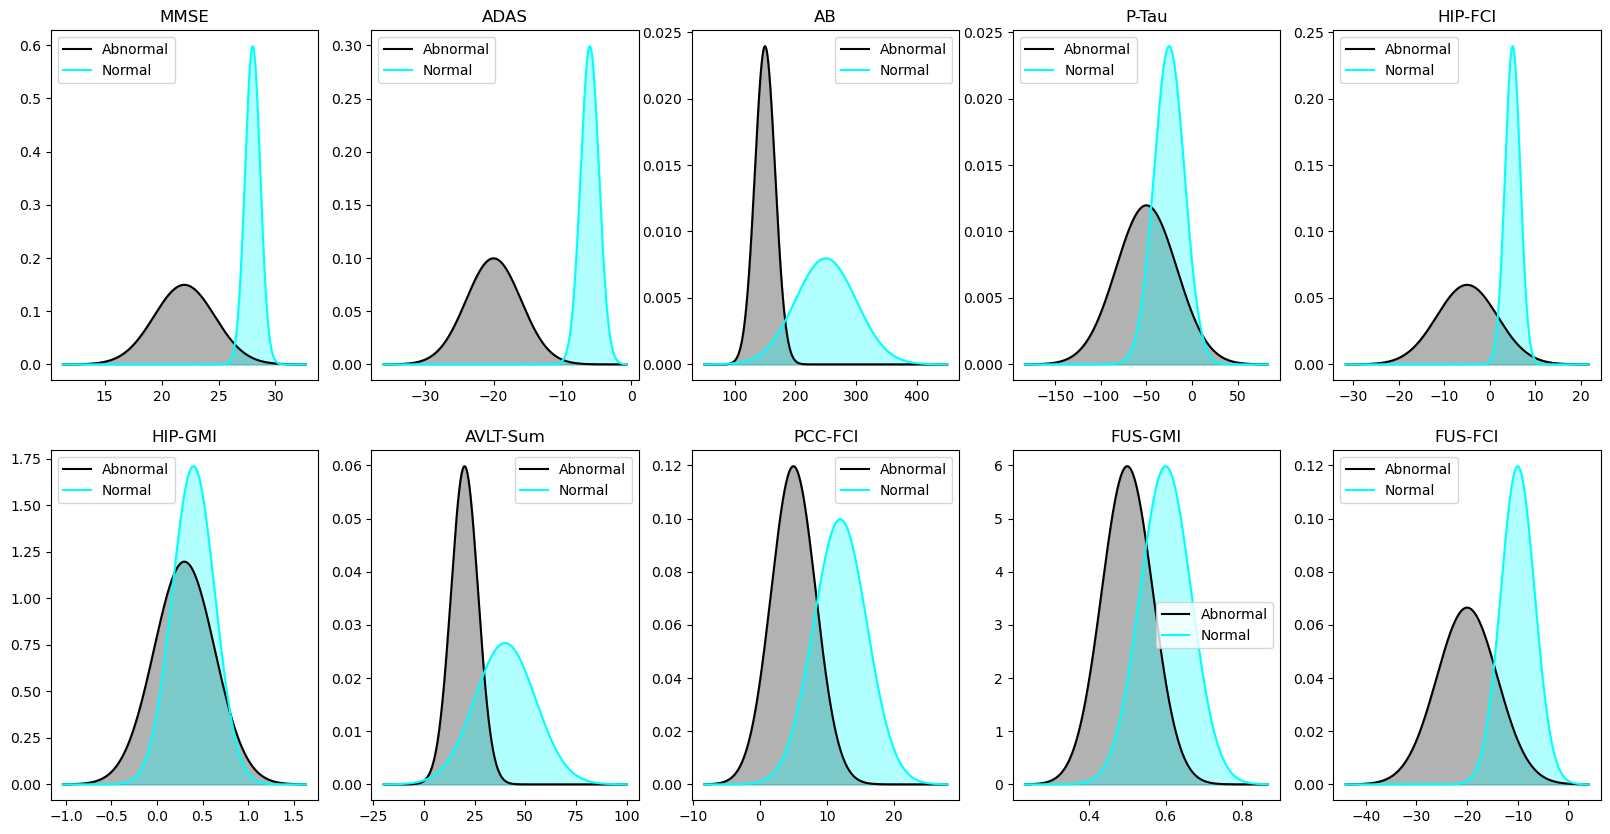

In [18]:
#| code-fold: true
#| fig-cap: evaluate theta and phi estimations
#| label: fig-eval-theta-phi-estimations

biomarkers = all_ten_biomarker_names
n_biomarkers = len(biomarkers)

def plot_distribution_pair(ax, mu1, sigma1, mu2, sigma2, title):
    """mu1, sigma1: theta
    mu2, sigma2: phi
    """
    xmin = min(mu1 - 4*sigma1, mu2-4*sigma2)
    xmax = max(mu1 + 4*sigma1, mu2 + 4*sigma2)
    x = np.linspace(xmin, xmax, 1000)
    y1 = stats.norm.pdf(x, loc = mu1, scale = sigma1)
    y2 = stats.norm.pdf(x, loc = mu2, scale = sigma2)
    ax.plot(x, y1, label = "Abnormal", color = "black")
    ax.plot(x, y2, label = "Normal", color = "cyan")
    ax.fill_between(x, y1, alpha = 0.3, color = "black")
    ax.fill_between(x, y2, alpha = 0.3, color = "cyan")
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(2, n_biomarkers//2, figsize=(20, 10))
for i, biomarker in enumerate(biomarkers):
    ax = axes.flatten()[i] 
    mu1, sigma1, mu2, sigma2 = real_theta_phi[
        real_theta_phi.biomarker == biomarker].reset_index().iloc[0, :][2:].values
    plot_distribution_pair(
        ax, mu1, sigma1, mu2, sigma2, title = biomarker)

You can compare this to @fig-chen1. 

## The Generating Process

In the following, we explain our data generation process. 

We have the following parameters:

$J$: Number of participants. 

$R$: The percentage of healthy participants. 

$M$: Number of datasets per combination of $j$ and $r$.

We set these parameters:

In [19]:
js = [50, 200, 500]
rs = [0.1, 0.25, 0.5, 0.75, 0.9]
num_of_datasets_per_combination = 50

So, there will be $3 \times 5 \times 50 = 750$ datasets to be generated.

We define our `generate_data_from_ebm` function:

In [20]:
#| code-fold: true
def generate_data_from_ebm(
    n_participants: int,
    S_ordering: List[str],
    real_theta_phi_file: str,
    healthy_ratio: float,
    output_dir: str,
    m,  # combstr_m
    seed: Optional[int] = 0
) -> pd.DataFrame:
    """
    Simulate an Event-Based Model (EBM) for disease progression.

    Args:
    n_participants (int): Number of participants.
    S_ordering (List[str]): Biomarker names ordered according to the order 
        in which each of them get affected by the disease.
    real_theta_phi_file (str): Directory of a JSON file which contains 
        theta and phi values for all biomarkers.
        See real_theta_phi.json for example format.
    output_dir (str): Directory where output files will be saved.
    healthy_ratio (float): Proportion of healthy participants out of n_participants.
    seed (Optional[int]): Seed for the random number generator for reproducibility.

    Returns:
    pd.DataFrame: A DataFrame with columns 'participant', "biomarker", 'measurement', 
        'diseased'.
    """
    # Parameter validation
    assert n_participants > 0, "Number of participants must be greater than 0."
    assert 0 <= healthy_ratio <= 1, "Healthy ratio must be between 0 and 1."

    # Set the seed for numpy's random number generator
    rng = np.random.default_rng(seed)

    # Load theta and phi values from the JSON file
    try:
        with open(real_theta_phi_file) as f:
            real_theta_phi = json.load(f)
    except FileNotFoundError:
        raise FileNotFoundError(f"File {real_theta_phi} not fount")
    except json.JSONDecodeError:
        raise ValueError(
            f"File {real_theta_phi_file} is not a valid JSON file.")

    n_biomarkers = len(S_ordering)
    n_stages = n_biomarkers + 1

    n_healthy = int(n_participants * healthy_ratio)
    n_diseased = int(n_participants - n_healthy)

    # Generate disease stages
    kjs = np.concatenate((np.zeros(n_healthy, dtype=int),
                         rng.integers(1, n_stages, n_diseased)))
    # shuffle so that it's not 0s first and then disease stages bur all random
    rng.shuffle(kjs)

    # Initiate biomarker measurement matrix (J participants x N biomarkers) with None
    X = np.full((n_participants, n_biomarkers), None, dtype=object)

    # Create distributions for each biomarker
    theta_dist = {biomarker: stats.norm(
        real_theta_phi[biomarker]['theta_mean'],
        real_theta_phi[biomarker]['theta_std']
    ) for biomarker in S_ordering}

    phi_dist = {biomarker: stats.norm(
        real_theta_phi[biomarker]['phi_mean'],
        real_theta_phi[biomarker]['phi_std']
    ) for biomarker in S_ordering}

    # Populate the matrix with biomarker measurements
    for j in range(n_participants):
        for n, biomarker in enumerate(S_ordering):
            # because for each j, we generate X[j, n] in the order of S_ordering,
            # the final dataset will have this ordering as well.
            k_j = kjs[j]
            S_n = n + 1

            # Assign biomarker values based on the participant's disease stage
            # affected, or not_affected, is regarding the biomarker, not the participant
            if k_j >= 1:
                if k_j >= S_n:
                    # rvs() is affected by np.random()
                    X[j, n] = (
                        j, biomarker, theta_dist[biomarker].rvs(random_state=rng), k_j, S_n, 'affected')
                else:
                    X[j, n] = (j, biomarker, phi_dist[biomarker].rvs(random_state=rng),
                               k_j, S_n, 'not_affected')
            # if the participant is healthy
            else:
                X[j, n] = (j, biomarker, phi_dist[biomarker].rvs(random_state=rng),
                           k_j, S_n, 'not_affected')

    df = pd.DataFrame(X, columns=S_ordering)
    # make this dataframe wide to long
    df_long = df.melt(var_name="Biomarker", value_name="Value")
    data = df_long['Value'].apply(pd.Series)
    data.columns = ['participant', "biomarker",
                    'measurement', 'k_j', 'S_n', 'affected_or_not']

    # biomarker_name_change_dic = dict(
    #     zip(S_ordering, range(1, n_biomarkers + 1)))
    data['diseased'] = data.apply(lambda row: row.k_j > 0, axis=1)
    # data.drop(['k_j', 'S_n', 'affected_or_not'], axis=1, inplace=True)
    # data['biomarker'] = data.apply(
    #     lambda row: f"{row.biomarker} ({biomarker_name_change_dic[row.biomarker]})", axis=1)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    filename = f"{int(healthy_ratio*n_participants)}|{n_participants}_{m}"
    data.to_csv(f'{output_dir}/{filename}.csv', index=False)
    # print("Data generation done! Output saved to:", filename)
    return data

In [21]:
S_ordering = np.array([
    'HIP-FCI', 'PCC-FCI', 'AB', 'P-Tau', 'MMSE', 'ADAS', 
    'HIP-GMI', 'AVLT-Sum', 'FUS-GMI', 'FUS-FCI'
])

# where the generated data will be saved
output_dir = 'data'

# We run the following only once; once the data is generated, we no longer run it
# We still show the codes to present our generation process
torun = False

In [22]:
#| eval: false

if torun:
    real_theta_phi_file = 'files/real_theta_phi.json'
    for j in js:
        for r in rs:
            for m in range(0, num_of_datasets_per_combination):
                generate_data_from_ebm(
                    n_participants=j,
                    S_ordering=S_ordering,
                    real_theta_phi_file=real_theta_phi_file,
                    healthy_ratio=r,
                    output_dir=output_dir,
                    m=m,
                    seed = int(j*10 + (r * 100) + m),
                )
        print(f'Done for J={j}')

## Visualize Synthetic Data

Above, we have generated 750 datasets, named in the fashion of `150|200_3`, which means the third dataset when $j = 200$ and $r = 0.75$.

Next, we try to visualize this dataset.

In [23]:
df = pd.read_csv(f"{output_dir}/150|200_3.csv")
df.head()

,participant,biomarker,measurement,k_j,S_n,affected_or_not,diseased
0,0,HIP-FCI,3.135981,0,1,not_affected,False
1,1,HIP-FCI,12.593704,2,1,affected,True
2,2,HIP-FCI,6.220776,0,1,not_affected,False
3,3,HIP-FCI,3.545100,0,1,not_affected,False
4,4,HIP-FCI,3.966541,0,1,not_affected,False


In [24]:
df.shape

(2000, 7)

This dataset has $2000$ rows because we have $200$ participants and $10$ biomarkers. 

### Distribution of all biomarker values

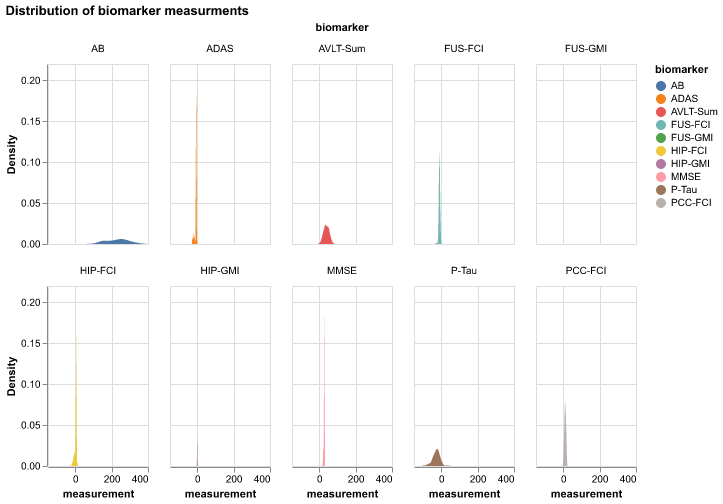

In [25]:
#| code-fold: true
#| fig-cap: "Distribution of biomarker measurments"
#| label: fig-dist-biomarker-vals

alt.renderers.enable('png')
alt.Chart(df).transform_density(
    'measurement',
    as_=['measurement', 'Density'],
    groupby=['biomarker']
).mark_area().encode(
    x="measurement:Q",
    y="Density:Q",
    facet = alt.Facet(
        "biomarker:N",
        columns = 5
    ),
    color=alt.Color(
        'biomarker:N'
    )
).properties(
    width= 100,
    height = 180,
).properties(
    title='Distribution of biomarker measurments'
)

### Distribution of A Specific Biomarker

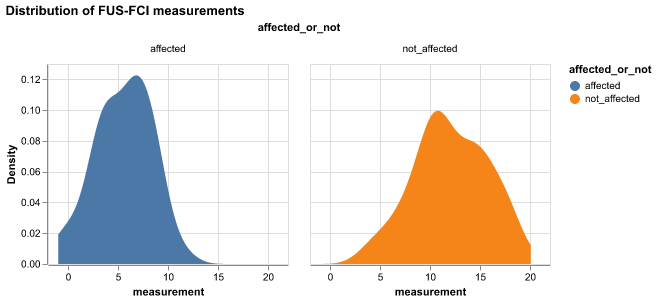

In [26]:
#| code-fold: true
#| fig-cap: Distribution of HIP-FCI measurements, compring bewteen affected and non-affected group
#| label: fig-dist-specific-biomarker-vals

idx = 1
biomarkers = df.biomarker.unique()
bio_data = df[df.biomarker==biomarkers[idx]]
alt.Chart(bio_data).transform_density(
    'measurement',
    as_=['measurement', 'Density'],
    groupby=['affected_or_not']
).mark_area().encode(
    x="measurement:Q",
    y="Density:Q",
    facet = alt.Facet(
        "affected_or_not:N",
    ),
    color=alt.Color(
        'affected_or_not:N'
    )
).properties(
    width= 240,
    height = 200,
).properties(
    title=f'Distribution of {biomarker} measurements'
)

### Looking into A Specific Participant

In [27]:
pidx = 1
p_data = df[df.participant == pidx]
p_data

,participant,biomarker,measurement,k_j,S_n,affected_or_not,diseased
1,1,HIP-FCI,12.593704,2,1,affected,True
201,1,PCC-FCI,7.164017,2,2,affected,True
401,1,AB,182.033823,2,3,not_affected,True
601,1,P-Tau,-25.345325,2,4,not_affected,True
801,1,MMSE,27.600823,2,5,not_affected,True
1001,1,ADAS,-4.920415,2,6,not_affected,True
1201,1,HIP-GMI,0.099052,2,7,not_affected,True
1401,1,AVLT-Sum,30.270797,2,8,not_affected,True
1601,1,FUS-GMI,0.658954,2,9,not_affected,True
1801,1,FUS-FCI,-11.701559,2,10,not_affected,True


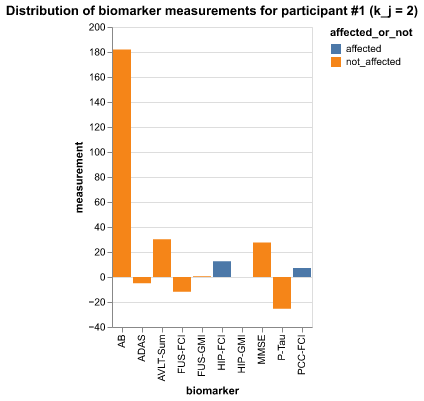

In [28]:
#| code-fold: true
#| fig-cap: Distribution of biomarker measurements for a specific participant
#| label: fig-dist-biomarker-vals-for-participant

pidx =1 # participant index
p_data = df[df.participant == pidx]
alt.Chart(p_data).mark_bar().encode(
    x='biomarker',
    y='measurement',
    color=alt.Color(
        'affected_or_not:N'
    ),
    tooltip=['biomarker', 'affected_or_not', 'measurement']
).interactive().properties(
    title=f'Distribution of biomarker measurements for participant #{idx} (k_j = {p_data.k_j.to_list()[0]})'
)